In [1]:
import pandas as pd
import numpy as np

In [2]:
#获得特征矩阵和标签矩阵
def get_Mat(path):
    dataSet = pd.read_table(path,header = None)
    xMat = np.mat(dataSet.iloc[:,:-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

xMat,yMat = get_Mat('simpdata.txt')

In [3]:
xMat

matrix([[1. , 2.1],
        [1.5, 1.6],
        [1.3, 1. ],
        [1. , 1. ],
        [2. , 1. ]])

In [4]:
yMat

matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simhei']
%matplotlib inline

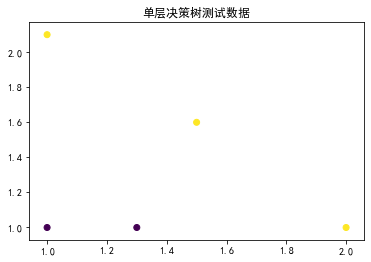

In [6]:
#数据集可视化函数
def showPlot(xMat,yMat):
    x=np.array(xMat[:,0])
    y=np.array(xMat[:,1])
    label = np.array(yMat)
    plt.scatter(x,y,c=label)
    plt.title('单层决策树测试数据')
    plt.show()

showPlot(xMat,yMat)

In [7]:
"""
函数功能：单层决策树分类函数
参数说明:
    xMat: 特征矩阵
    i: 第i列，也就是第几个特征
    Q: 阈值
    S: 标志
返回:
    re: 分类结果
构建第二个函数寻找最佳单层决策树：
测试函数并运行查看结果：
"""

def Classify0(xMat,i,Q,S):
    re = np.ones((xMat.shape[0],1)) #初始化re为1
    if S == 'lt':
        re[xMat[:,i] <= Q] = -1 #如果小于阈值,则赋值为-1
    else:
        re[xMat[:,i] > Q] = -1 #如果大于阈值,则赋值为-1
        
    return re

In [8]:
"""
函数功能：找到数据集上最佳的单层决策树
参数说明:
xMat：特征矩阵
yMat：标签矩阵
D：样本权重
返回:
bestStump：最佳单层决策树信息
minE：最小误差
bestClas：最佳的分类结果
"""
def get_Stump(xMat,yMat,D):
    m,n = xMat.shape                                #m为样本个数，n为特征数             
    Steps = 10                                      #初始化一个步数
    bestStump = {}                                  #用字典形式来储存树桩信息
    bestClas = np.mat(np.zeros((m,1)))              #初始化分类结果为1
    minE = np.inf                                   #最小误差初始化为正无穷大
    
    for i in range(n):                              #遍历所有特征
        Min = xMat[:,i].min()                       #找到特征中最小值
        Max = xMat[:,i].max()                       #找到特征中最大值
        stepSize = (Max - Min) / Steps              #计算步长
        for j in range(-1, int(Steps)+1):                                     
            for S in ['lt', 'gt']:                  #大于和小于的情况，均遍历。lt:less than，gt:greater than
                Q = (Min + j * stepSize)            #计算阈值
                re = Classify0(xMat, i, Q, S)       #计算分类结果
                err = np.mat(np.ones((m,1)))        #初始化误差矩阵
                err[re == yMat] = 0                 #分类正确的,赋值为0
                eca = D.T * err                     #计算误差
                #print(f'切分特征: {i}, 阈值:{np.round(Q,2)}, 标志:{S}, 权重误差:{np.round(eca,3)}')
                if eca < minE:                      #找到误差最小的分类方式
                    minE = eca
                    bestClas = re.copy()
                    bestStump['特征列'] = i
                    bestStump['阈值'] = Q
                    bestStump['标志'] = S
                    
    return bestStump,minE,bestClas

In [9]:
m = xMat.shape[0]
D = np.mat(np.ones((m, 1)) / m) #初始化样本权重（每个样本权重相等）
# print(D)
bestStump,minE,bestClas= get_Stump(xMat,yMat,D)
bestStump, minE, bestClas

({'特征列': 0, '阈值': 1.3, '标志': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [15]:
"""
函数功能：基于单层决策树的AdaBoost训练过程
参数说明：
    xMat：特征矩阵
    yMat：标签矩阵
    maxC：最大迭代次数
返回：
    weakClass：弱分类器信息
    aggClass：类别估计值（其实就是更改了标签的估计值）
"""
def Ada_train(xMat, yMat, maxC = 40):
    weakClass = []
    m = xMat.shape[0]
    D = np.mat(np.ones((m, 1)) / m) #初始化权重
    aggClass = np.mat(np.zeros((m,1)))
    
    for i in range(maxC):
        Stump, error, bestClas = get_Stump(xMat, yMat,D) #构建单层决策树
        #print(f"D:{D.T}")
        alpha=float(0.5 * np.log((1 - error) / max(error, 1e-16))) #计算弱分类器权重alpha
        Stump['alpha'] = np.round(alpha,2) #存储弱学习算法权重,保留两位小数
        weakClass.append(Stump) #存储单层决策树
        #print("bestClas: ", bestClas.T)
        
        expon = np.multiply(-1 * alpha *yMat, bestClas) #计算e的指数项
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum() #根据样本权重公式，更新样本权重
        
        aggClass += alpha * bestClas #更新累计类别估计值
        
        print(f"aggClass: {aggClass.T}" )
        aggErr = np.multiply(np.sign(aggClass) != yMat, np.ones((m,1)))#计算误差
        errRate = aggErr.sum() / m
    
        print(f"分类错误率: {errRate}")
        if errRate == 0: 
            break #误差为0，退出循环
        
    return weakClass, aggClass

In [16]:
weakClass, aggClass =Ada_train(xMat, yMat, maxC = 40)
weakClass, aggClass

aggClass: [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
分类错误率: 0.2
aggClass: [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
分类错误率: 0.2
aggClass: [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
分类错误率: 0.0


([{'特征列': 0, '阈值': 1.3, '标志': 'lt', 'alpha': 0.69},
  {'特征列': 1, '阈值': 1.0, '标志': 'lt', 'alpha': 0.97},
  {'特征列': 0, '阈值': 0.9, '标志': 'lt', 'alpha': 0.9}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

In [17]:
"""
函数功能：AdaBoost分类函数
参数说明：
data: 待分类样例
classifys:训练好的分类器
返回:
分类结果
"""
def AdaClassify(data,weakClass):
    dataMat = np.mat(data)
    m = dataMat.shape[0]
    aggClass = np.mat(np.zeros((m,1)))
    print(f'len(weakClass):{len(weakClass)}')
    for i in range(len(weakClass)): #遍历所有分类器，进行分类
        classEst = Classify0(dataMat,
        weakClass[i]['特征列'],
        weakClass[i]['阈值'],
        weakClass[i]['标志'])
        
        aggClass += weakClass[i]['alpha'] * classEst
        #print(aggClass)
        
    return np.sign(aggClass)

In [18]:
AdaClassify(xMat,weakClass)

len(weakClass):3


matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


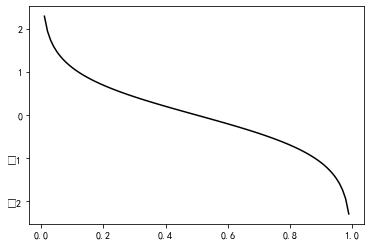

In [27]:
x = np.linspace(0, 1, 100)
print(x)
y = 0.5 * np.log((1-x) / x)
print(y)
plt.plot(x, y, c='black')
plt.show()